M0     495  1
MX      21  0
M1       6  2
'--      5

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I' : 0, 'Stage II' : 0, 'Stage III' : 0, 'Stage IVA' : 1, 'Stage IVB' : 1, 'Stage IVC' : 1})
clinical_df = clinical_df[['case_id', 'path_stage_strat', 'days_to_death']]

#df = pd.read_csv('rnaseq_all.tsv', sep='\t')
#df = pd.read_csv('rnaseq_s1.tsv', sep='\t')
#df = pd.read_csv('rnaseq_s2.tsv', sep='\t')
df = pd.read_csv('rnaseq_s1_s2.tsv', sep='\t')

df = pd.merge(df, pd.read_csv('file_to_case.tsv', sep='\t'), on='file_id', how='left')
df = pd.merge(df, clinical_df, on='case_id', how='left')
dtd = df['days_to_death']
df = df.drop(columns=['file_id', 'case_id', 'days_to_death']).dropna()

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

acc0 = []
acc1 = []

for i in range(100):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    import xgboost as xgb
    from sklearn.metrics import f1_score
    classifier = xgb.XGBClassifier()
    classifier.fit(X_train, y_train)

    a = pd.concat([pd.Series(classifier.predict_proba(X_test)[:, 0]), y_test.reset_index(drop=True)], axis=1)
    acc0.append(sum(a[a[0] > 0.9]['path_stage_strat'] == 0) / len(a[a[0] > 0.9]))
    acc1.append(sum(a[a[0] < 0.1]['path_stage_strat'] == 1) / len(a[a[0] < 0.1]))

print(np.mean(acc0))
print(np.mean(acc1))

0.5555535983624218
0.6529152521007506


In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

from keras.layers import Input, Dense
input_img = Input(shape=(X.shape[1],))
encoded = Dense(X.shape[1], activation='relu')(input_img)
encoded = Dense(X.shape[1], activation='relu')(encoded)
encoded = Dense(1, activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(decoded)
decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

from keras.models import Model
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
decoder = Model(encoded, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X, X, epochs=120, batch_size=256, validation_split=0.2, verbose=0)

X = encoder.predict(X)

acc0 = []
acc1 = []

for i in range(100):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    import xgboost as xgb
    from sklearn.metrics import f1_score
    classifier = xgb.XGBClassifier()
    classifier.fit(X_train, y_train)

    a = pd.concat([pd.Series(classifier.predict_proba(X_test)[:, 0]), y_test.reset_index(drop=True)], axis=1)
    if(len(a[a[0] > 0.9]) != 0 and len(a[a[0] < 0.1]) != 0):
        acc0.append(sum(a[a[0] > 0.9]['path_stage_strat'] == 0) / len(a[a[0] > 0.9]))
        acc1.append(sum(a[a[0] < 0.1]['path_stage_strat'] == 1) / len(a[a[0] < 0.1]))

print(np.mean(acc0))
print(np.mean(acc1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.39299999999999996
0.3462619047619047


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


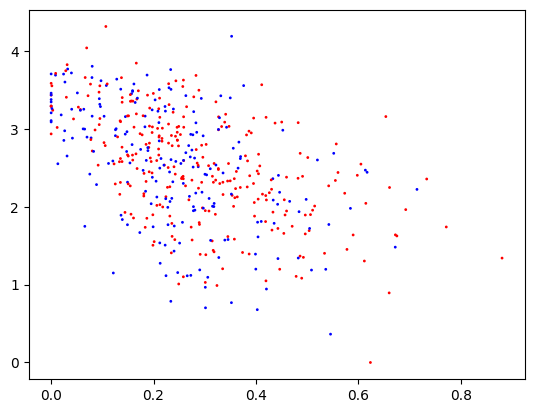

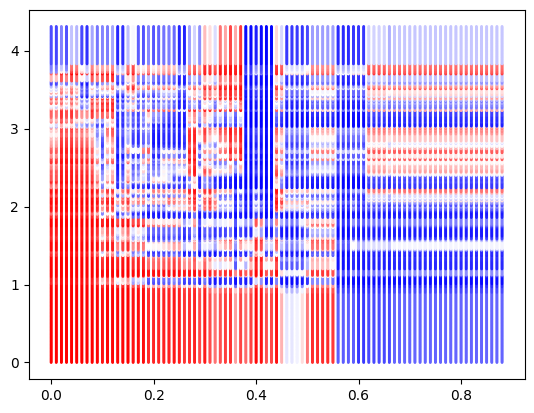

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

from keras.layers import Input, Dense
input_img = Input(shape=(X.shape[1],))
encoded = Dense(X.shape[1], activation='relu')(input_img)
encoded = Dense(X.shape[1], activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(decoded)
decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

from keras.models import Model
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
decoder = Model(encoded, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X, X, epochs=120, batch_size=256, validation_split=0.2, verbose=0)

X = encoder.predict(X)

import xgboost as xgb
classifier = xgb.XGBClassifier()
classifier.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=1, alpha=1)
plt.show()

inter = 0.01
Xs = np.column_stack((np.meshgrid(np.arange(X[:, 0].min(), X[:, 0].max(), inter), np.arange(X[:, 1].min(), X[:, 1].max(), inter))[0].ravel(), np.meshgrid(np.arange(X[:, 0].min(), X[:, 0].max(), inter), np.arange(X[:, 1].min(), X[:, 1].max(), inter))[1].ravel()))
plt.scatter(Xs[:, 0], Xs[:, 1], c=classifier.predict_proba(Xs)[:, 0], cmap='bwr', s=1, alpha=1)
plt.show()


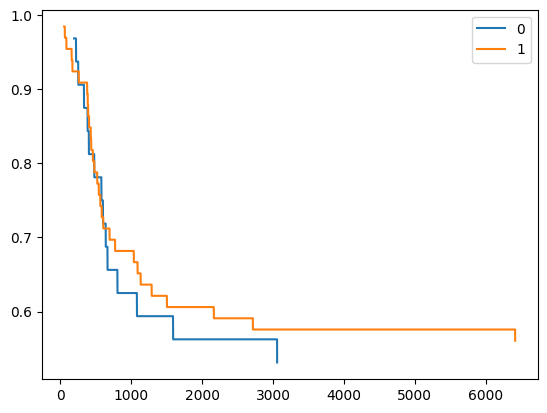

In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

acc0 = []
acc1 = []

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

import xgboost as xgb
from sklearn.metrics import f1_score
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

def OS(col, lab):
    a = col.replace("'--", np.NaN).dropna().apply(pd.to_numeric).sort_values()
    b = pd.Series(1 - (np.arange(len(a)) + 1) / len(col))
    b.index = a
    b = b[~b.index.duplicated(keep='last')].reindex(list(range(b.index.min(),b.index.max()+1))).fillna(method='ffill')
    plt.plot(b, label=lab)

OS(dtd[X_test.index][y_pred == 0], '0')
OS(dtd[X_test.index][y_pred == 1], '1')

plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


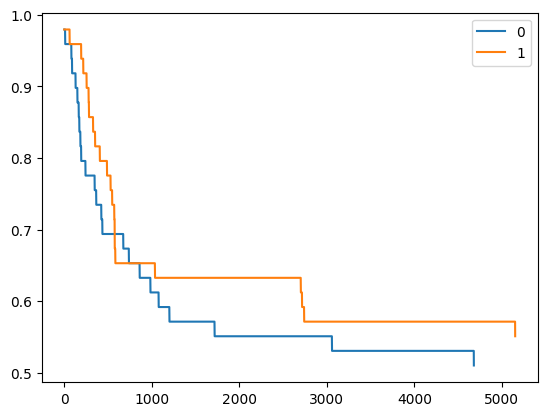

In [7]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

from keras.layers import Input, Dense
input_img = Input(shape=(X.shape[1],))
encoded = Dense(X.shape[1], activation='relu')(input_img)
encoded = Dense(X.shape[1], activation='relu')(encoded)
encoded = Dense(1, activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='relu')(decoded)
decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

from keras.models import Model
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
decoder = Model(encoded, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X, X, epochs=120, batch_size=256, validation_split=0.2, verbose=0)

X = pd.Series(encoder.predict(X).reshape(-1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

import xgboost as xgb
from sklearn.metrics import f1_score
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

def OS(col, lab):
    a = col.replace("'--", np.NaN).dropna().apply(pd.to_numeric).sort_values()
    b = pd.Series(1 - (np.arange(len(a)) + 1) / len(col))
    b.index = a
    b = b[~b.index.duplicated(keep='last')].reindex(list(range(b.index.min(),b.index.max()+1))).fillna(method='ffill')
    plt.plot(b, label=lab)

OS(dtd[X_test.index][y_pred == 0], '0')
OS(dtd[X_test.index][y_pred == 1], '1')

plt.legend()
plt.show()